# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

# 1. Pipeline for single image

## Import Packages

In [19]:
# Import some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


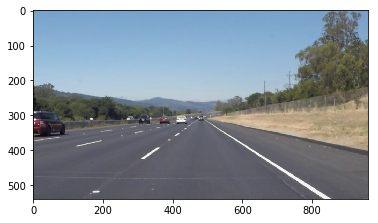

In [20]:
# Read in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg') # returns numpy.array with shape (M, N, 3)

# Print out some stats and plot
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Canny edge detection

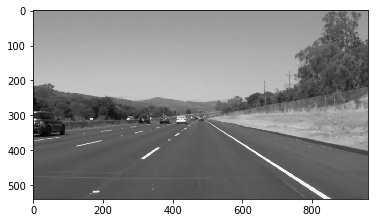

In [21]:
# Grayscale the image
image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

cv2.imwrite('test_images_output/grayscale.jpg', image_gray)

# Display the image
plt.imshow(image_gray, cmap="gray")

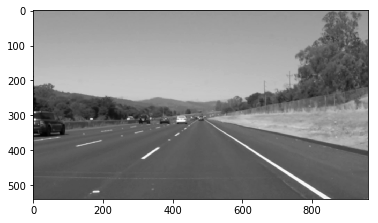

In [22]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
image_blur_gray = cv2.GaussianBlur(image_gray, (kernel_size, kernel_size), 0)

cv2.imwrite('test_images_output/gaussian.jpg', image_blur_gray)

# Display the image
plt.imshow(image_blur_gray, cmap="gray")

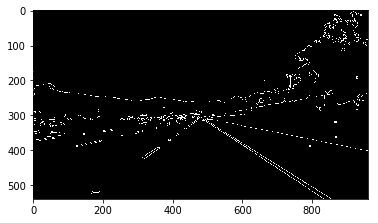

In [23]:
# Define parameters for Canny edge detection and apply
low_threshold = 30
high_threshold = 150
image_edges = cv2.Canny(image_blur_gray, low_threshold, high_threshold)

cv2.imwrite('test_images_output/canny.jpg', image_edges)

# Display the image
plt.imshow(image_edges, cmap="gray")

## Create masked edges image

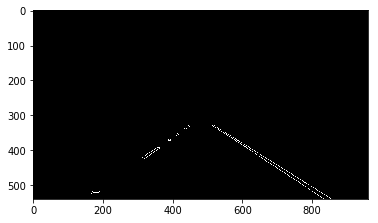

In [24]:
# Create a masked edges image
mask = np.zeros_like(image_edges)    
ignore_mask_color = 255   

# Define a four sided polygon to mask
imshape = image.shape
min_y = 330
max_y = imshape[0]
vertices = np.array([[(120,max_y),(420, min_y), (540, min_y), (880,max_y)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
image_masked_edges = cv2.bitwise_and(image_edges, mask) # Grayscale image!

cv2.imwrite('test_images_output/masked.jpg', image_masked_edges)

plt.imshow(image_masked_edges, cmap="gray")
# plt.imshow(mask, cmap="gray")

## Hough transformation

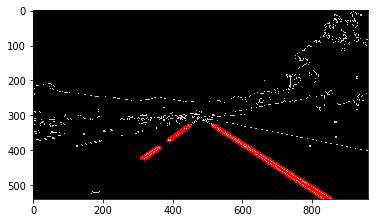

In [25]:
# Define Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 # minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
image_lines = np.copy(image)*0 # creating a blank color image to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(image_masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image_lines,(x1,y1), (x2,y2), (255,0,0), 10)

# Create a 3 channel binary image to combine with line image
image_masked_edges_color = np.dstack((image_edges, image_edges, image_edges)) 

# Draw the lines on the original image
image_lines_edges = cv2.addWeighted(image_masked_edges_color, 0.8, image_lines, 1, 0) 

cv2.imwrite('test_images_output/hough.jpg', cv2.cvtColor(image_lines_edges, cv2.COLOR_RGB2BGR))

plt.imshow(image_lines_edges)

## Line extrapolation

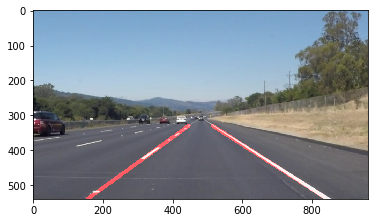

In [26]:
image_lines_extrapolated = np.copy(image)*0 # creating a blank color image to draw lines on

# Calculate slopes of all lines using slope = (y2-y1)/(x2-x1), assign a slope of 0 for vertical lines
# lines (x_1, y_1, _x_2, y_2)
d_y = (lines[:,0,3] - lines[:,0,1]) 
d_x = (lines[:,0,2] - lines[:,0,0])

slopes = np.divide(d_y, d_x, out = np.zeros_like(d_x, dtype=float), where = d_x != 0)

# Select all lines that are part of the right lane boundary (corresponds with positive slope). Ignore vertical lines.
positive_slopes = (slopes > 0.5)
right_lines = lines[positive_slopes,:,:]

# Select all lines that are part of the left lane boundary (corresponds with negative slope). Ignore vertical lines.
negative_slopes = (slopes < -0.5)
left_lines = lines[negative_slopes,:,:]

'''
for line in right_lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image,(x1,y1), (x2,y2), (255,0,0), 10)
        
for line in left_lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image,(x1,y1), (x2,y2), (0,255,0), 10)
        
plt.imshow(image)
'''

# Calculate first degree polynomial for right lane boundary
# We have to define the polynomial inverse since we know min_y and max_y (see above) but not min_x and max_x
right_lines_x = np.concatenate((right_lines[:,0,0], right_lines[:,0,2]), axis=None)
right_lines_y = np.concatenate((right_lines[:,0,1], right_lines[:,0,3]), axis=None)
fit_right_boundary = np.polyfit(right_lines_y, right_lines_x, 1) # inverse definition
f_right = np.poly1d([fit_right_boundary[0], fit_right_boundary[1]]) # poly1d([a, b]) returns object representing ax + b

# Calculate first degree polynomial for left lane boundary
left_lines_x = np.concatenate((left_lines[:,0,0], left_lines[:,0,2]), axis=None)
left_lines_y = np.concatenate((left_lines[:,0,1], left_lines[:,0,3]), axis=None)
fit_left_boundary = np.polyfit(left_lines_y, left_lines_x, 1) # inverse definition
f_left = np.poly1d([fit_left_boundary[0], fit_left_boundary[1]]) # poly1d([a, b]) returns object representing ax + b

# Draw line from (f_right(min_y), min_y) to (f_right(max_y), max_y)
cv2.line(image_lines_extrapolated, (int(f_right(min_y)), min_y), (int(f_right(max_y)), max_y), (255,0,0), 10)
cv2.line(image_lines_extrapolated, (int(f_left(min_y)), min_y), (int(f_left(max_y)), max_y), (255,0,0), 10)

# Draw the lines on the original image
image_final = cv2.addWeighted(image_lines_extrapolated, 0.8, image, 1, 0) 

cv2.imwrite('test_images_output/extrapolated.jpg', cv2.cvtColor(image_final, cv2.COLOR_RGB2BGR))

plt.imshow(image_final)

## Write image to file

In [27]:
cv2.imwrite('test_images_output/solidWhiteRight.jpg', cv2.cvtColor(image_final, cv2.COLOR_RGB2BGR))

True

# 2. Test pipeline with multiple images

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Build the pipeline and run your solution on all test_images. Make copies into the test_images_output directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

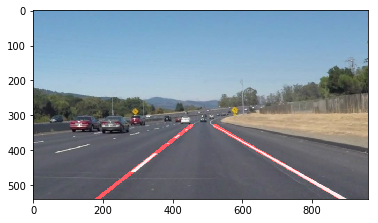

In [28]:
import os
image_names = os.listdir("test_images/")

# Parameter for Gaussian smoothing
kernel_size = 5

# Parameters for Canny edge detection
low_threshold = 30
high_threshold = 150

# Parameters for masking
imshape = image.shape
min_y = 330
max_y = imshape[0]
min_x_left = 120
max_x_left = 420
min_x_right = 540
max_x_right = 890
ignore_mask_color = 255

# Parameters for Hough transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 # minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

# Returns grayscale image
def apply_grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Returns grayscale image
def apply_gaussian(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Returns grayscale image
def apply_canny_edge(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

# Returns grayscale image
def mask(image, min_x_left, max_x_left, min_x_right, max_x_right, min_y, max_y, ignore_mask_color):
    mask = np.zeros_like(image_edges)
    
    # Define a four sided polygon to mask
    vertices = np.array([[(min_x_left, max_y), (max_x_left, min_y), (min_x_right, min_y), (max_x_right, max_y)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

# Returns lines
def calculate_hough_transform(image, rho, theta, threshold, min_line_length, max_line_gap):
    # Run Hough on edge detected image
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Returns color picture
def apply_hough_transform(image, original, lines):
    # Iterate over the output "lines" and draw lines on a blank image
    image_lines = np.copy(original)*0
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image_lines,(x1,y1), (x2,y2), (255,0,0), 10)
            
    # Create a 3 channel binary image to combine with line image
    image_masked_edges_color = np.dstack((image, image, image)) 

    # Draw the lines on the original image
    return cv2.addWeighted(image_masked_edges_color, 0.8, image_lines, 1, 0)

def separate_lane_boundaries(lines):
    # Calculate slopes of all lines using slope = (y2-y1)/(x2-x1), assign a slope of 0 for vertical lines
    d_y = (lines[:,0,3] - lines[:,0,1]) 
    d_x = (lines[:,0,2] - lines[:,0,0])
    slopes = np.divide(d_y, d_x, out = np.zeros_like(d_x, dtype=float), where = d_x != 0)

    # Select all lines that are part of the right lane boundary (positive slope). Ignore vertical lines.
    positive_slopes = (slopes > 0.5)
    right_lines = lines[positive_slopes,:,:]
    # Select all lines that are part of left lane boundary (negative slope). Ignore vertical lines.
    negative_slopes = (slopes < -0.5)
    left_lines = lines[negative_slopes,:,:]
    
    return right_lines, left_lines

def calculate_polynomial(lines):
    # Calculate inverse first degree polynomial for lane boundary
    lines_x = np.concatenate((lines[:,0,0], lines[:,0,2]), axis=None)
    lines_y = np.concatenate((lines[:,0,1], lines[:,0,3]), axis=None)
    fit_boundary = np.polyfit(lines_y, lines_x, 1)
    return np.poly1d([fit_boundary[0], fit_boundary[1]])

def draw_lines(original, functions, min_y, max_y):
    image_lines_extrapolated = np.copy(original)*0
    
    for f in functions:
        cv2.line(image_lines_extrapolated, (int(f(min_y)), min_y), (int(f(max_y)), max_y), (255,0,0), 10)

    # Draw lines on original image
    return cv2.addWeighted(image_lines_extrapolated, 0.8, original, 1, 0) 

for image_name in image_names:
    # Read in an image
    image = mpimg.imread('test_images/' + image_name)
    
    image_gray = apply_grayscale(image)
    image_blur_gray = apply_gaussian(image_gray, kernel_size)
    image_edges = apply_canny_edge(image_blur_gray, low_threshold, high_threshold)
    image_masked_edges = mask(image_edges, min_x_left, max_x_left, min_x_right, max_x_right, min_y, max_y, ignore_mask_color)
    lines = calculate_hough_transform(image_masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    image_lines_edges = apply_hough_transform(image_masked_edges, image, lines)
    right_lines, left_lines = separate_lane_boundaries(lines)
    f_right = calculate_polynomial(right_lines)
    f_left = calculate_polynomial(left_lines)
    image_final = draw_lines(image, (f_right, f_left), min_y, max_y)
    plt.imshow(image_final)

    cv2.imwrite('test_images_output/' + image_name, cv2.cvtColor(image_final, cv2.COLOR_RGB2BGR))

# 3. Pipeline for video

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image(image):
    image_gray = apply_grayscale(image)
    image_blur_gray = apply_gaussian(image_gray, kernel_size)
    image_edges = apply_canny_edge(image_blur_gray, low_threshold, high_threshold)
    image_masked_edges = mask(image_edges, min_x_left, max_x_left, min_x_right, max_x_right, min_y, max_y, ignore_mask_color)
    lines = calculate_hough_transform(image_masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    image_lines_edges = apply_hough_transform(image_masked_edges, image, lines)
    right_lines, left_lines = separate_lane_boundaries(lines)
    f_right = calculate_polynomial(right_lines)
    f_left = calculate_polynomial(left_lines)
    result = draw_lines(image, (f_right, f_left), min_y, max_y)
    return result

Let's try the one with the solid white lane on the right first ...

In [31]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 49.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.99 s, sys: 392 ms, total: 3.38 s
Wall time: 5.59 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [38]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:16<00:00, 42.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.44 s, sys: 1.69 s, total: 11.1 s
Wall time: 16.8 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
